# Classify using convolutional neural network (CNN)

In [1]:
import numpy as np
from os.path import join
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, LeakyReLU, Flatten, Dropout, Input
from tensorflow.keras import Sequential
import keras
from tensorflow.keras.callbacks import EarlyStopping

import pickle

2025-02-19 13:31:02.927650: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 13:31:02.936517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739968262.945860   22799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739968262.948555   22799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 13:31:02.958879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 7

# size of sample used to train the model
NUM_SAMPLES = 10000

Load the data prepared in previous notebook

In [4]:
# Load data
with np.load(join(DATA_PATH, 'train_data.npz')) as data:
    data_dict=dict(data.items())
X = data_dict['X']
y = data_dict['y']

Optionally subsample the data for faster training during try-outs

In [5]:
import random

# Get a smaller random sample 
idx = random.sample(range(len(X)-1), NUM_SAMPLES)
X = X[idx]
y = y[idx]

Rescale the data, one-hot encode the labels

In [6]:
# Convert pixels into floating point numbers
#data = X.astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (X.astype(np.float32) - 128) / 255

In [7]:
# Split into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(
#    # Reshape images
#    data.reshape(-1, input_width, input_height, input_depth), # Single channel (grayscale)
#    y,
#    test_size=500, random_state=0
#)
X = X.reshape(-1, input_width, input_height, input_depth)
# Print shape
#print('Train:', X_train.shape, y_train.shape)
#print('Test:', X_test.shape, y_test.shape)

In [8]:
# convert class vectors to binary class matrices
classes, y = np.unique(y, return_inverse=True)
y = keras.utils.to_categorical(y, output_classes)

Display some images as a check

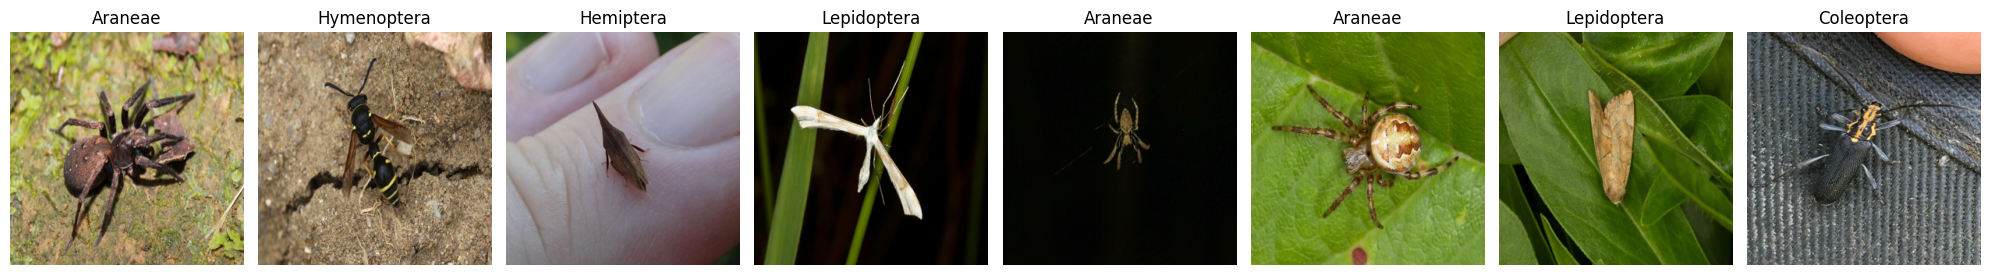

In [9]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

check_images = 8
idx = random.sample(range(len(X)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    class_name = classes[list(y[id]).index(1)]
    ax[i].set_title(class_name)
    ax[i].axis('off')
plt.tight_layout()
plt.show();

Define the model

In [10]:
model = Sequential([
    Input(shape=input_shape)
])
# conv layer
model.add(
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
)
# max pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# conv layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(MaxPool2D(pool_size=(2, 2))
)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(output_classes, activation='softmax')
)
model.summary()

2025-02-19 13:31:24.495727: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 341056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 341056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │     2,387,399 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,791 (9.18 MB)

 Trainable params: 2,406,791 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Define loss function, optimizer, and metrics to track during training
model.compile(
    optimizer='adam', # .. or optimizers.SGD(lr=0.01)
    loss='categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['accuracy'] # .. or metrics.sparse_categorical_accuracy
)

Fit the model

In [12]:
%%time
callback = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(
    x=X, y=y,
    validation_split=0.1, batch_size=128, epochs=15,
    callbacks=[callback]
)

Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.1522 - loss: 651.2737 - val_accuracy: 0.1540 - val_loss: 1.9419
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.2056 - loss: 1.9019 - val_accuracy: 0.1680 - val_loss: 1.9571
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.3174 - loss: 1.7216 - val_accuracy: 0.1820 - val_loss: 2.1073
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.4192 - loss: 1.4717 - val_accuracy: 0.1890 - val_loss: 2.2898
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5080 - loss: 1.2682 - val_accuracy: 0.1820 - val_loss: 2.6623
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.5732 - loss: 1.0889 - val_accuracy: 0.1750 - val_loss: 3.1421
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.6393 - loss: 0.9424 - val_accuracy: 0.1790 - val_loss: 3.6363
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.6791 - loss: 0.8635 - val_accuracy: 0.1800 -

Display loss and accuracy curves for train and validation

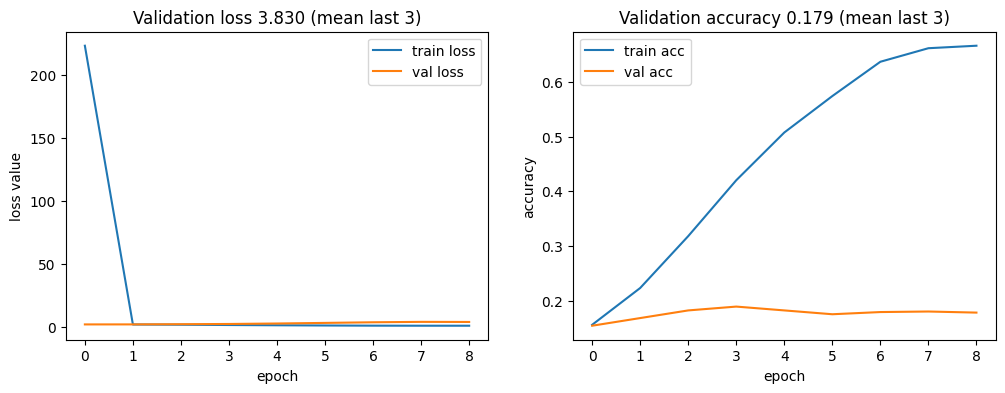

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['accuracy'], label='train acc')
ax2.plot(history.history['val_accuracy'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

## Save the model

In [16]:
with open(join(MODELS_PATH, 'cnn.pickle'), 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)